### Opis

Wybraliśmy DCGAN, czyli GAN z warstwami splotowymi jako nasz model generatywny.

### Imports

In [1]:
#%matplotlib inline
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import os
import math

from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch.autograd import Variable

import torch.nn.functional as F
import torch

### Seeds

In [2]:
torch.manual_seed(42)  # Sets up seed for both devices
np.random.seed(42)
random.seed(42)

### Device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Parameters

In [4]:
n_epochs = 200
batch_size = 128
lr = 0.0002
b1 = 0.5  # decay of first order momentum of gradient
b2 = 0.999
latent_dim = 200
img_size = 32
channels = 3
sample_interval = 800  # interval between image sampling

### Data loading & transformations

In [5]:
dataset = ImageFolder(root='traffic_32',
                      transform=transforms.Compose([
                          transforms.Resize(img_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

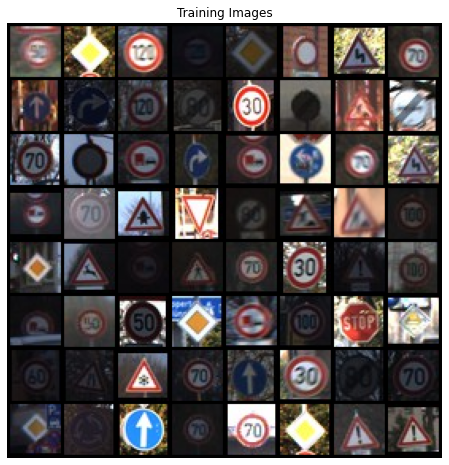

In [6]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

### Generator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=channels, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

### Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_channels=in_filters, out_channels=out_filters, kernel_size=(3, 3), stride=(2, 2),
                               padding=1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(in_features=128 * ds_size ** 2, out_features=1),
                                       nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

### Prepare for training

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [10]:
adversarial_loss = torch.nn.BCELoss().to(device)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [11]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [12]:
os.makedirs("images", exist_ok=True)

### Training

In [13]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------------------------------------------------------------------------------------------------------------------------------------
        #  Train Generator
        # -----------------------------------------------------------------------------------------------------------------------------------------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------------------------------------------------------------------------------------------------------------------------------------
        #  Train Discriminator
        # ---------------------------------------------------------------------------------------------------------------------------------------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
            save_image(gen_imgs.data[:25], f"images/{batches_done}.png", nrow=5, normalize=True)



[Epoch 0/200] [Batch 0/307] [D loss: 0.6932669281959534] [G loss: 0.6781578660011292]
[Epoch 2/200] [Batch 186/307] [D loss: 0.6917964220046997] [G loss: 0.698269248008728]
[Epoch 5/200] [Batch 65/307] [D loss: 0.6952912211418152] [G loss: 0.6393470764160156]
[Epoch 7/200] [Batch 251/307] [D loss: 0.6819966435432434] [G loss: 0.6945366859436035]
[Epoch 10/200] [Batch 130/307] [D loss: 0.6770193576812744] [G loss: 0.7453269958496094]
[Epoch 13/200] [Batch 9/307] [D loss: 0.6986074447631836] [G loss: 0.7571226358413696]
[Epoch 15/200] [Batch 195/307] [D loss: 0.6351638436317444] [G loss: 0.6846573352813721]
[Epoch 18/200] [Batch 74/307] [D loss: 0.854697048664093] [G loss: 0.5739604234695435]
[Epoch 20/200] [Batch 260/307] [D loss: 0.6690993309020996] [G loss: 0.802564263343811]
[Epoch 23/200] [Batch 139/307] [D loss: 0.6358672380447388] [G loss: 0.807074785232544]
[Epoch 26/200] [Batch 18/307] [D loss: 0.5631518959999084] [G loss: 0.736802339553833]
[Epoch 28/200] [Batch 204/307] [D los

In [14]:
torch.save(discriminator.state_dict(), 'discriminatorv2.tar')
torch.save(generator.state_dict(), 'generatorv2.tar')

### Generate and save 1000 images

In [15]:
imgs = next(iter(dataloader))[0]
print(imgs.shape)
z = Variable(Tensor(np.random.normal(0, 1, (1000, latent_dim))))
print(z.shape)

torch.Size([128, 3, 32, 32])
torch.Size([1000, 200])


In [16]:
out = generator(z)

In [17]:
print(out.shape)

torch.Size([1000, 3, 32, 32])


In [18]:
print(len(out))

1000


In [19]:
torch.save(out.cpu().detach(), 'out.pt')